# Collaborative Filtering

## Factorization Machines

extend the idea of matrix factorization by modeling not only the interaction between two features (as in user-item interactions) but also any higher-order interactions between features in a dataset

In [6]:
import numpy as np
import pandas as pd
import ast

import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.multiprocessing
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

torch.manual_seed(21)
np.random.seed(21)

# ratings = pd.read_csv('/kaggle/input/ml-1m-data/ml-1m/ratings.dat', delimiter='::', engine='python', names=['userId', 'movieId', 'rating', 'timestamp'])
# users = pd.read_csv('/kaggle/input/ml-1m-data/ml-1m/users.dat', delimiter='::', engine='python', names=['userId', 'gender', 'age', 'occupation', 'zip-code'])
# movies = pd.read_csv('/kaggle/input/ml-1m-data/ml-1m/movies.dat', delimiter='::', engine='python', names=['movieId', 'title', 'genres'], encoding='ISO-8859-1')

users = pd.read_csv('/kaggle/input/gamers/game_data_prepared/users.csv')
ratings = pd.read_csv('/kaggle/input/gamers/game_data_prepared/ratings.csv')
gamesF = pd.read_csv('/kaggle/input/gamers/game_data_prepared/games.csv')

gamesF['tags'] = gamesF['tags'].apply(ast.literal_eval)

In [7]:
train_ratings, test_ratings = train_test_split(
    ratings, test_size=0.15, random_state=21
)

product_category have 4 ranges: 3-80, 80-500, 500-1000, 1000+

In [8]:
bins = [3, 80, 500, 1000, float('inf')]
labels = [0, 1, 2, 3]
users['product_category'] = pd.cut(users['products'], bins=bins, labels=labels, right=False)

In [9]:
users

,user_id,products,reviews,product_category
0,6366584,1597,107,3
1,11402551,444,108,1
2,5047735,1941,113,3
3,5337314,1252,182,3
4,5382866,2723,87,3
...,...,...,...,...
7634,8340518,433,102,1
7635,8458227,405,214,1
7636,8706224,211,95,1
7637,8769179,449,111,1


In [10]:
import pandas as pd

# Calculate average hours for each user based on they like, dislike a game
avg_hours = ratings.groupby(['user_id', 'is_recommended'])['hours'].mean().unstack(fill_value=0)
avg_hours.columns = ['hours_played_dislike', 'hours_played_like']
users = users.merge(avg_hours, on='user_id', how='left')

users

,user_id,products,reviews,product_category,hours_played_dislike,hours_played_like
0,6366584,1597,107,3,9.089744,52.169118
1,11402551,444,108,1,11.371875,20.470455
2,5047735,1941,113,3,10.613333,31.054082
3,5337314,1252,182,3,0.275000,15.229775
4,5382866,2723,87,3,9.700000,22.442308
...,...,...,...,...,...,...
7634,8340518,433,102,1,25.755882,18.708824
7635,8458227,405,214,1,18.171429,2.699034
7636,8706224,211,95,1,18.000000,54.361798
7637,8769179,449,111,1,0.400000,4.583486


hours_played_category have 5 ranges: 0-10, 10-30, 30-50, 50-100, 100+

10 more index

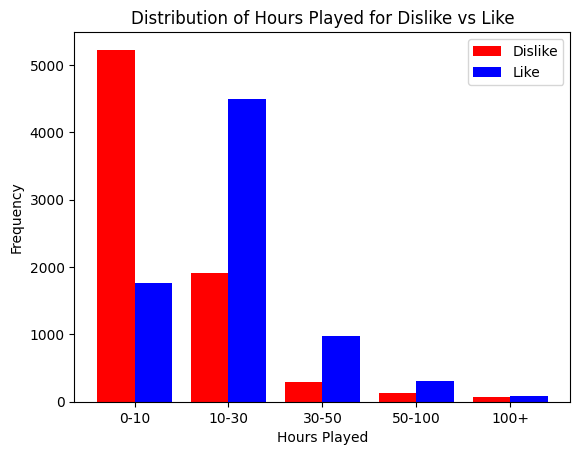

In [11]:
import matplotlib.pyplot as plt

bins = [0, 10, 30, 50, 100, np.inf]
bin_labels = ['0-10', '10-30', '30-50', '50-100', '100+']
# (0, 10], (10-30], ...

dislike_counts, _ = np.histogram(users['hours_played_dislike'], bins=bins)
like_counts, _ = np.histogram(users['hours_played_like'], bins=bins)
bar_width = 0.4
bar_positions = np.arange(len(bins) - 1)

plt.bar(bar_positions - bar_width/2, dislike_counts, width=bar_width, color='red', label='Dislike')
plt.bar(bar_positions + bar_width/2, like_counts, width=bar_width, color='blue', label='Like')
plt.xticks(bar_positions, bin_labels)
plt.xlabel('Hours Played')
plt.ylabel('Frequency') 
plt.title('Distribution of Hours Played for Dislike vs Like')
plt.legend()

plt.show()

We can all see that, if somebody do not like some games, they will just abandon that game right from begining

For the users who play longer then dislike mean that they might find bug, hack or something dislike but the dev dont fix so they dislike, not each exactly that game they dont like to play

In [12]:
bins = [0, 10, 30, 50, 100, np.inf]
labels = [0, 1, 2, 3, 4]
users['hours_played_dislike_category'] = pd.cut(users['hours_played_dislike'], bins=bins, labels=labels, right=False)
users['hours_played_like_category'] = pd.cut(users['hours_played_like'], bins=bins, labels=labels, right=False)

In [13]:
users

,user_id,products,reviews,product_category,hours_played_dislike,hours_played_like,hours_played_dislike_category,hours_played_like_category
0,6366584,1597,107,3,9.089744,52.169118,0,3
1,11402551,444,108,1,11.371875,20.470455,1,1
2,5047735,1941,113,3,10.613333,31.054082,1,2
3,5337314,1252,182,3,0.275000,15.229775,0,1
4,5382866,2723,87,3,9.700000,22.442308,0,1
...,...,...,...,...,...,...,...,...
7634,8340518,433,102,1,25.755882,18.708824,1,1
7635,8458227,405,214,1,18.171429,2.699034,1,0
7636,8706224,211,95,1,18.000000,54.361798,1,3
7637,8769179,449,111,1,0.400000,4.583486,0,0


In [14]:
users = users.drop(columns=['hours_played_like'])
users = users.drop(columns=['hours_played_dislike'])

In [15]:
# ratings[(ratings['user_id'] == 8507454) & (ratings['is_recommended'] == 0)]

In [16]:
user_index_by_id = {id: idx for idx, id in enumerate(users["user_id"]) }
product_category_offset = len(users) 
hours_played_like_category_offset = product_category_offset + 4  # 4 product categories
hours_played_dislike_category_offset = hours_played_like_category_offset + 5  # 5 like categories

user_features = []

for index, row in users.iterrows():
    user_index = int(index)  
    product_category_index = int(product_category_offset + row['product_category'])
    hours_played_like_category_index = int(hours_played_like_category_offset + row['hours_played_like_category'])
    hours_played_dislike_category_index = int(hours_played_dislike_category_offset + row['hours_played_dislike_category'])
    
    user_features.append([
        user_index,
        product_category_index,
        hours_played_like_category_index,
        hours_played_dislike_category_index
    ])

For users: index of 7639 users, 4 product_category, 5 hours_played_like_category and 5 hours_played_dislike_category. The total is 7653.

In [17]:
user_features[1]

[1, 7640, 7644, 7649]

In [18]:
users

,user_id,products,reviews,product_category,hours_played_dislike_category,hours_played_like_category
0,6366584,1597,107,3,0,3
1,11402551,444,108,1,1,1
2,5047735,1941,113,3,1,2
3,5337314,1252,182,3,0,1
4,5382866,2723,87,3,0,1
...,...,...,...,...,...,...
7634,8340518,433,102,1,1,1
7635,8458227,405,214,1,1,0
7636,8706224,211,95,1,1,3
7637,8769179,449,111,1,0,0


user 1, products 80-500, hours_played_like 10-30, hours_played_dislike 10-30

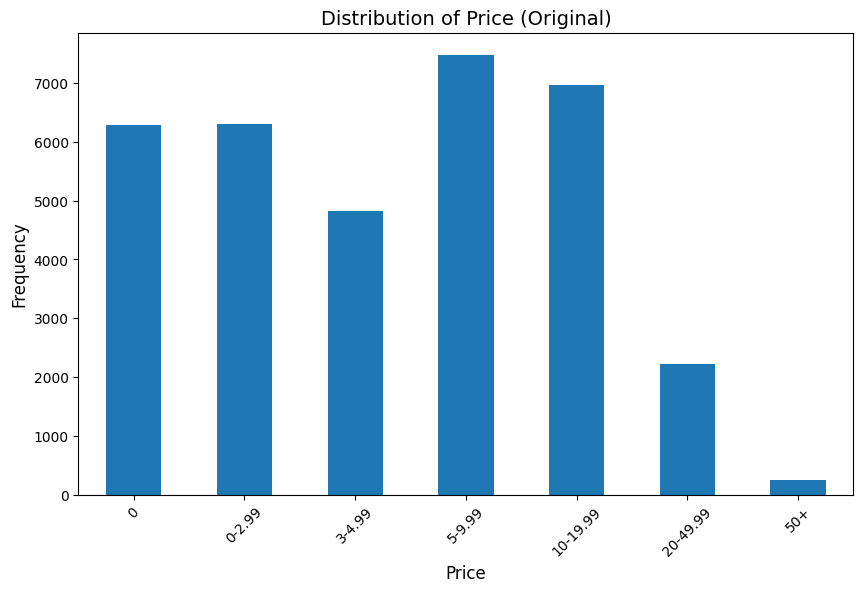

In [19]:
import matplotlib.pyplot as plt

bins = [0, 0.1, 3, 5, 10, 20, 50, float('inf')]
labels = ['0', '0-2.99', '3-4.99', '5-9.99', '10-19.99', '20-49.99', '50+']

# Create a new column for binned data
gamesF['price_bins'] = pd.cut(gamesF['price_original'], bins=bins, labels=labels, right=False)

# Plot histogram
plt.figure(figsize=(10, 6))
gamesF['price_bins'].value_counts(sort=False).plot(kind='bar')
plt.title('Distribution of Price (Original)', fontsize=14)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.show()

gamesF = gamesF.drop(columns=["price_bins"])

In [20]:
unique_tags = set(tag for tags_list in gamesF['tags'] for tag in tags_list)
tags = sorted(unique_tags)

In [21]:
ratings_ordered = [
    "Overwhelmingly Negative",
    "Very Negative",
    "Mostly Negative",
    "Negative",
    "Mixed",
    "Mostly Positive",
    "Positive",
    "Very Positive",
    "Overwhelmingly Positive"
]

game_offset = 7653 
tag_offset = game_offset + len(gamesF)  
rating_offset = tag_offset + len(tags)  
price_offset = rating_offset + len(ratings_ordered)  

game_index_by_id = {app_id: idx for idx, app_id in enumerate(gamesF["app_id"])}
tag_index_by_name = {tag: i for i, tag in enumerate(tags)}
rating_index_by_name = {rating: i for i, rating in enumerate(ratings_ordered)}

bins = [0, 0.1, 3, 5, 10, 20, 50, float('inf')]
price_bins = pd.cut(gamesF["price_original"], bins=bins, labels=False, right=False)

game_features = []
for i, row in gamesF.iterrows():
    game_feature = [game_offset + i]  # Game index
    for tag in row["tags"]:
        tag_index = tag_index_by_name[tag] + tag_offset
        game_feature.append(tag_index) # Add tag index
    # Add rating index
    rating_index = rating_index_by_name[row["rating"]] + rating_offset
    game_feature.append(rating_index)

    # Add price bin index
    price_bin_index = price_bins[i] + price_offset
    game_feature.append(int(price_bin_index))

    game_features.append(game_feature)

For gamesF: index of 34320 games, 441 tags, 9 rating types and 7 price ranges. Start games at 7653, tags at 7653+34320=41973, rating types at 41973+441=42414, price ranges at 42414+9=42423. The total is 42430.

In [22]:
game_features[10]

[7663, 42340, 42142, 42410, 42155, 42276, 42313, 42421, 42427]

gameid 10, 6 different kind of tags, Very Positive Rating, 10-19.99 price_original

In [23]:
gamesF.iloc[10]

app_id                                                        22130
title                                     Hearts of Iron 2 Complete
date_release                                             2009-01-23
win                                                            True
mac                                                           False
linux                                                         False
rating                                                Very Positive
positive_ratio                                                   85
user_reviews                                                    462
price_original                                                14.99
tags              [Strategy, Grand Strategy, World War II, Histo...
Name: 10, dtype: object

We will save an array containing the indices of the elements equal to one of the feature vectors of the user and the game. Because these arrays have different sizes, to be able to train in batches, we need to add pad at the end so that the arrays have equal sizes.

In [24]:
game_offset

7653

In [25]:
# total_inputs

In [26]:
NUM_GAMES = len(gamesF)
NUM_USERS = len(users)
total_inputs = game_offset + NUM_GAMES + len(tags) + len(ratings_ordered) + 7 # 7 is number price ranges
padding_idx = total_inputs


class FactorizationMachineDataset(Dataset):
    def __init__(self, rating_df):
        self.rating_df = rating_df
        self.max_size = 5 + len(tags) + 2  # user feature:4 + game index:1 + tags + rating + price

    def __len__(self):
        return len(self.rating_df)

    def __getitem__(self, index):
        user_index = user_index_by_id[self.rating_df["user_id"].iloc[index]]
        game_index = game_index_by_id[self.rating_df["app_id"].iloc[index]]
        rating = self.rating_df["is_recommended"].iloc[index]
        user_feature = user_features[user_index]
        game_feature = game_features[game_index]
        padding_size = self.max_size - len(user_feature) - len(game_feature)
        feature = user_feature + game_feature + [padding_idx] * padding_size
        return torch.IntTensor(feature), torch.tensor(rating, dtype=torch.float32)


training_data = FactorizationMachineDataset(train_ratings)
test_data = FactorizationMachineDataset(test_ratings)

batch_size = 1024*5
num_workers = 4

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, persistent_workers=True)

test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [27]:
from pytorch_lightning.loggers import TensorBoardLogger

LR = 5e-4
WEIGHT_DECAY = 5e-5


class FactorizationMachine(pl.LightningModule):
    def __init__(self, num_inputs, num_factors):
        super(FactorizationMachine, self).__init__()
        self.embedding = nn.Embedding(num_inputs + 1, num_factors, padding_idx=padding_idx)
        self.embedding.weight.data.uniform_(-.1, .1)
        torch.nn.init.xavier_normal_(self.embedding.weight.data, gain=1e-3)
        self.linear_layer = nn.Embedding(num_inputs+1, 1, padding_idx=padding_idx)
        self.bias = nn.Parameter(data=torch.rand(1))
    

    def forward(self, x):
        emb = self.embedding(x)
        pow_of_sum = emb.sum(dim=1, keepdim=True).pow(2).sum(dim=2)
        sum_of_pow = emb.pow(2).sum(dim=1, keepdim=True).sum(dim=2)
        out_inter = 0.5 * (pow_of_sum - sum_of_pow)
        out_lin = self.linear_layer(x).sum(1)
        out = out_inter + out_lin + self.bias

        return torch.clip(out.squeeze(), min=0, max=1)

    def training_step(self, batch, batch_idx):
        inputs, rating = batch
        rating = rating.to(torch.float32).squeeze(-1)  # 1D
        output = self.forward(inputs).squeeze(-1)      # 1D
        # print("Rating shape:", rating.shape)          
        # print("Output shape:", output.shape)
        loss = F.mse_loss(rating, output)
        self.log("batch_loss", loss)
        return {"loss": loss}

#     def validation_step(self, batch, batch_idx):
#         inputs, rating = batch
#         rating = rating.to(torch.float32)
#         output = self.forward(inputs)
#         loss = F.mse_loss(rating, output)
#         self.log("batch_loss", loss)
#         return {"loss": loss}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        return optimizer

In [ ]:
n_factors = 120
logger = TensorBoardLogger(
    "logs", name=f"ilr{LR}_wd{WEIGHT_DECAY}_emb{n_factors}_b{batch_size}"
)

model = FactorizationMachine(num_inputs=total_inputs, num_factors=n_factors)
trainer = pl.Trainer(accelerator='gpu', max_epochs=50, logger=logger)

trainer.fit(model, train_dataloader, test_dataloader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# model_path = "factorization_machine.pt"
# torch.save(model, model_path)

In [28]:
# model = torch.load("/kaggle/input/gamers/factorization_machine.pt")
# model.eval()

/tmp/ipykernel_30/1831144058.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/kaggle/input/gamers/factorization_machine.pt")


FactorizationMachine(
  (embedding): Embedding(42431, 120, padding_idx=42430)
  (linear_layer): Embedding(42431, 1, padding_idx=42430)
)

In [26]:
eval_batch_size = 1024*20
train_dataloader = DataLoader(training_data, batch_size=eval_batch_size, shuffle=False, num_workers=num_workers)
test_dataloader = DataLoader(test_data, batch_size=eval_batch_size, shuffle=False, num_workers=num_workers)

In [27]:
def eval_model(model, dataloader):
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad(): 
        for feature, rating in dataloader:
            feature, rating = feature.to(model.device), rating.to(model.device)
            
            pred = model(feature).squeeze(-1) 
            loss = F.mse_loss(pred, rating, reduction='sum') 
            total_loss += loss.item()
            total_samples += len(rating)
    
    RMSE = (total_loss / total_samples) ** 0.5
    return RMSE

print("Train RMSE: {:.3f}".format(eval_model(model, train_dataloader)))
print("Validation RMSE: {:.3f}".format(eval_model(model, test_dataloader)))

Train RMSE: 0.345
Validation RMSE: 0.369


In [ ]:
# def eval_model(model, train_dataloader):
#     loss = 0
#     for feature, rating in train_dataloader:
#         pred = model(feature)
#         loss += F.mse_loss(pred, rating)
#     RMSE = (loss / len(train_dataloader))**.5
#     return RMSE

# print("Train RMSE: {:.3f}".format(eval_model(model, train_dataloader)))
# print("Validation RMSE: {:.3f}".format(eval_model(model, test_dataloader)))

In [55]:
num_games = len(gamesF)
embs_arr = model.state_dict()['embedding.weight'].detach().numpy()
game_tags = gamesF["tags"]
target_tags = {'Comedy', 'Drama', 'Horror'}

# Filter games that have exactly one of the target tags, not want point duplicate
game_inds_one_tag = [
    i for i, tags in enumerate(game_tags)
    if len(set(tags) & target_tags) == 1  
]
game_embs = embs_arr[game_offset: game_offset + num_games, :]
game_subset_embs = game_embs[game_inds_one_tag, :]

print(f"Number of selected games: {len(game_inds_one_tag)}")

Number of selected games: 6528


Embedding of these games is seen in two-dimensional space using t-SNE PCA:

In [56]:
game_subset_embs.shape # num_games_matched, n_factors

(6528, 120)

In [57]:
game_embs.shape

(34320, 120)

In [71]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

game_2d = TSNE(n_components=2, init='pca', perplexity=40, random_state=21).fit_transform(game_subset_embs)
game_df = pd.DataFrame(
    data={
        "x": game_2d[:, 0],
        "y": game_2d[:, 1],
        "tag": [list(set(tags) & target_tags)[0] for tags in game_tags[game_inds_one_tag]],
    }
)

High perplexity (e.g., 30–50): Captures more of the global structure, ensuring the broader patterns or clusters are preserved, suitable for data have many samples

In [73]:
# action_df = game_df[game_df["tag"] == "Comedy"]
# sports_df = game_df[game_df["tag"] == "Drama"]
# horror_df = game_df[game_df["tag"] == "Horror"]

# n_samples = 2001 // 3  
# action_sampled = action_df.sample(n=n_samples, random_state=21)
# sports_sampled = sports_df.sample(n=n_samples, random_state=21)
# horror_sampled = horror_df.sample(n=n_samples, random_state=21)

# balanced_df = pd.concat([action_sampled, sports_sampled, horror_sampled]).sample(frac=1, random_state=42)

In [74]:
# balanced_df

,x,y,tag
4763,30.750193,14.184092,Horror
5676,-42.749508,-13.072345,Comedy
5647,6.009566,50.211620,Horror
2013,-50.232338,-13.410349,Drama
1434,-15.409087,-17.283863,Drama
...,...,...,...
701,15.466555,-44.951202,Drama
1795,21.501343,-12.832335,Drama
2685,11.361726,-13.413337,Drama
2953,35.668079,1.256562,Horror


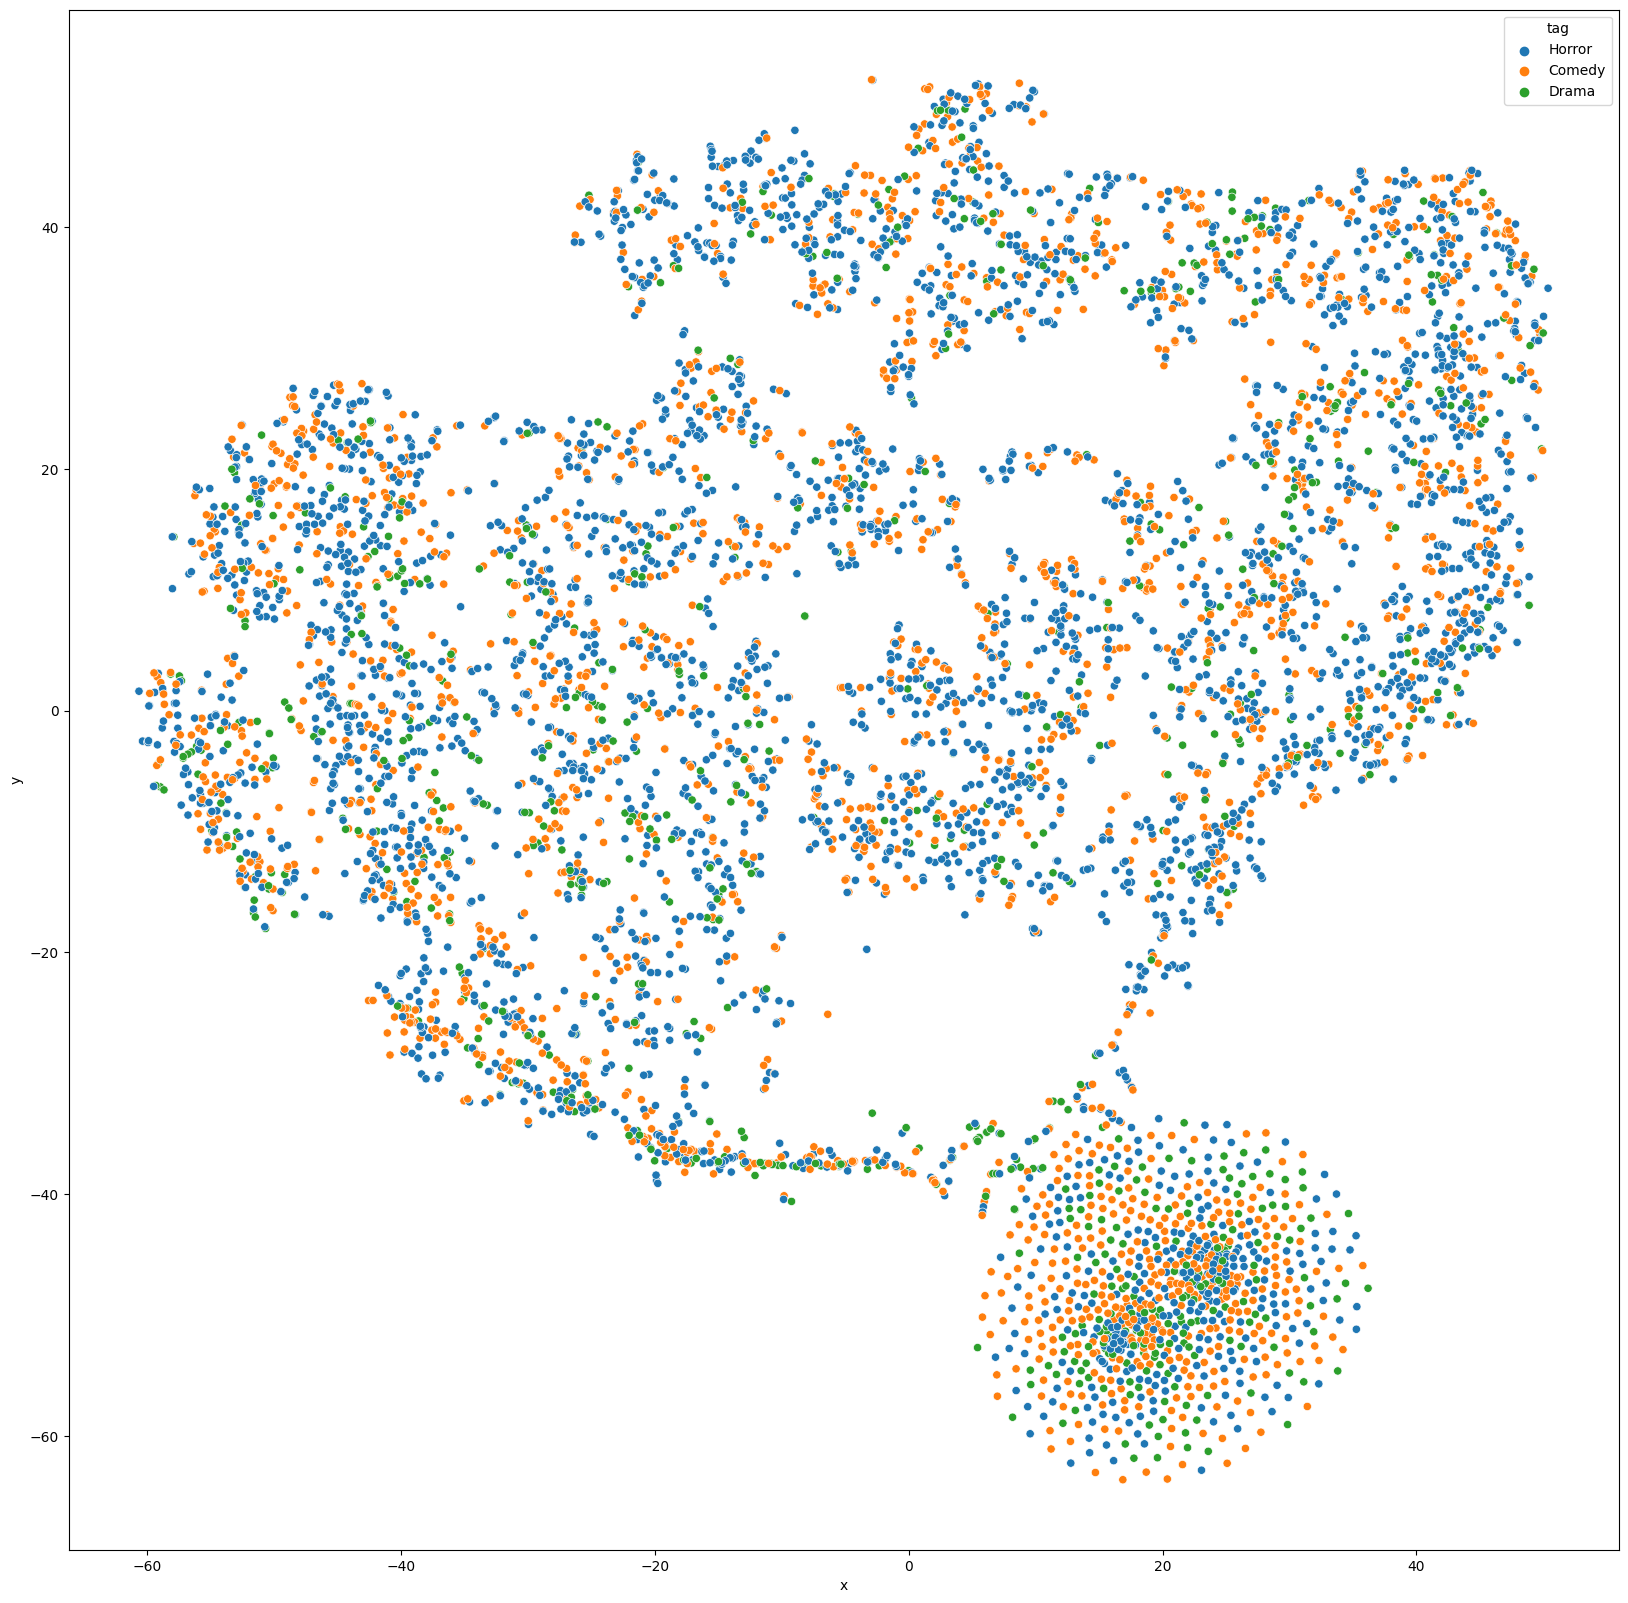

In [76]:
plt.figure(figsize=(20, 20))
ax = sns.scatterplot(x="x", y="y", hue='tag',data=game_df)

We can see that games of the same tag (same color) tend to focus on areas close to each other. This proves that FM has learned useful information from the data